In [6]:
import numpy as np
import matplotlib.pyplot as plt 

## Performance estimator tool using BEMT

$T\ =\ b\int_{Rc}^{R}dT$

$ P\ =\ b\int_{Rc}^{R}dP $

$\alpha_{effective\ }=\ \theta\ -\ \phi\ $

$\phi\ =\ \arctan\left(\frac{V+v}{\omega r}\right)$

$\theta = E + Fr$

$\sigma = \frac{bc}{\pi r}$

$$
\lambda =
\sqrt{
\left( \frac{\sigma a}{16F} - \frac{\lambda_c}{2} \right)^2
+ \frac{\sigma a}{8F} \, \theta \, \frac{r}{R}
}- \left( \frac{\sigma a}{16F} - \frac{\lambda_c}{2} \right)
$$

$$
\text{where,} \quad
\lambda_c = \frac{V}{\Omega R}, 
\quad 
\lambda = \frac{V + v}{\Omega R}
$$

$$
F = \frac{2}{\pi}cos^{-1}(e^{-f})    ; where  f = \frac{b(1-\frac{r}{R})}{\lambda} \\ 
dT = 4\pi\rho rF(V+v)vdr = 4\pi\rho rF(\lambda ω r)(λωr - V)dr \\
T\ =\ b\int_{Rc}^{R}dT
$$

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
class rotor:
    def __init__(self):

        #change accordingly, initial set at 3500 m
        self.temp = 288.15    # ambient is 288.15 K
        self.rho = 1.225      # ambient is 1.006kg/m3
        self.pressure = 101325 # ambient is 79500 Pa
        self.sound_speed = 340.29 # ambient is 340.29 m/s

        # only the payload considered initially
        self.m = 8 * 70    # 8 people, 70kg each
        self.b = 3
        self.r = 0.762         # radius defined = 0.762m
        self.rc = 0.125        # inner radius = 0.125m

        self.twist = 0         # all the angles in radian
        self.twist_slope = 0

        self.chord = 0.0508
        self.chord_slope = 0

        self.omega = 30    # omega in rad/sec

        # cl = a0 * alpha, alpha (alpha in rad )
        self.cl = 5.75
        # cd = cdo + ep*alpha (alpha in rad )
        self.cd = 1.25
        self.cdo = 0.0113

        self.V = None           # climb velocity
        self.lambda_c = None

    def integrate(self,x, y):
        """
        @brief Compute the integral ydx from [a,b], take the input as np.array
        """
        return np.trapz(y,x)

    def set_rotor(self, radius = 0.762, root_cut_out = 0.125, blades = 3, chord0 = 0.0508,chord_slope = 0,
              twist0 = 0, twist_slope = 0,omega = 30):
        """
        @brief defines the parameters for the rotor, set the angles and everything in terms of rad-1 and rad
        @param radius: outer radius of the rotor
        @param root_cut_out: radius, where the rotors start
        @param blades: number of blades
        @param chord0 = chord at r = root_cut_out
        @param chord_slope: slope of the chord, chord at radius r = chord + slope*(r-root_cut_out), keep the slope negative
        @param twist0 : twist at r = root_cut_out
        @param twist_slope: slope of the twist, twist at radius r = twist0 + slope*(r-root_cut_out)
        """
        self.r = radius
        self.rc = root_cut_out
        self.b = blades
        self.chord = chord0
        self.chord_slope = chord_slope
        self.twist = twist0
        self.twist_slope = twist_slope
        self.omega = omega

    def set_airfoil(self, cl = 5.75, cdo = 0.0113,cd = 1.25):
        """
        @brief call this func to change the airfoil parameters
        @param cl: cl_val = cl*alph
        @param cd: cd_val = cdo + cd*alpha^2
        """
        self.cl = cl
        self.cdo = cdo
        self.cd = cd

    def atmosphere(self, h, dT=0):
        """
        @brief used to set the ambient conditions at the given altitude, and also returns them
        @return temp (K)  pressure (Pa), density (kgm/3), speed of sound(m/s)
        """
        T = 288.15 - 0.0065*h + dT
        p = 101325 * (1 - 0.00198*h/288.16)**5.2553
        rho = 1.225 * (1 - 0.00198*h/288.16)**4.2553
        a = (1.4*287.05*T)**0.5
        self.temp, self.pressure, self.rho, self.sound_speed = T, p, rho, a
        return T, p, rho, a


    def cal_cl(self,alpha):
        return self.cl * alpha
    def cal_cd(self,alpha):
        return self.cdo + self.cd*alpha*alpha
    def cal_chord(self,x):                          ### local chord 
        return self.chord + self.chord_slope*(x-self.rc)
    def cal_twist(self,x):                          ### local twist
        return  self.twist + self.twist_slope*(x-self.rc)
    def cal_solidity(self,r):                       ### local solidity
        return self.b  *self.cal_chord(r)/(np.pi * r)      
    def cal_F(self, val_lambda, r):
        x = np.exp(-self.b/2 * (1 - r/self.r) / max(val_lambda, 1e-8))
        x = np.clip(x, 0.0, 1.0)
        return 2 * np.arccos(x) / np.pi

    def find_lambda(self,sigma,r,theta, tol = 1e-8,beta = 0.6,iterations = 100):   ## this is the iterative step to calculate lambda for a particular r
        guess = self.lambda_c      ### start with the initial guess as lambda_c
        for i in range(iterations):
            F = self.cal_F(guess,r)
            nxt = np.sqrt((sigma*self.cl/(16*F) - self.lambda_c/2)**2  +  (sigma*self.cl/(8*F))*theta*(r/self.r)) + self.lambda_c/2 - sigma*self.cl/(16*F) 
            if abs(nxt-guess) < tol:
                guess = nxt
                break
            guess = nxt* beta + (1-beta)*guess

        v = guess*self.omega*self.r - self.V        # induced velocity, local induced
        return guess,v,self.cal_F(guess,r)

    def bemt(self,V):       

        """
        @brief calculates everything - thrust, torque, lambda, induced velocity
        @param V: climb velocity   [define the rotor parameters and all before]
        @return: lambdas,v,sigma,twist, thrust ,dT,Fs,d_torque, torque

        """
        r = np.linspace(self.rc,self.r - 1e-6,1000)
        wt = self.omega*r
        self.V = V
        self.lambda_c = self.V/(self.omega * self.r)       ### global one

        sigma = np.array([self.cal_solidity(r[i]) for i in range(len(r))])
        twist = np.array([self.cal_twist(r[i]) for i in range(len(r))])

        ### calculating the parameters for thrust calculation
        lambdas = []
        Fs = []
        v = []
        for i in range(len(r)):
          temp_lambda , temp_v, temp_F = self.find_lambda (sigma[i],r[i],twist[i])
          lambdas.append(temp_lambda)
          v.append(temp_v)
          Fs.append(temp_F)

        ### thrust calculation
        v = np.array(v)
        lambdas = np.array(lambdas)
        Fs = np.array(Fs)
        dT = 4*np.pi*self.rho * r * Fs * v * (V+v)
        thrust = self.integrate(r,dT)

        ### torque calculation
        U2 = (self.omega * r)**2 + (self.V + v)**2
        chord = np.array([self.cal_chord(r[i]) for i in range(len(r))])

        phi = np.arctan((self.V + v) / (self.omega * r))
        alpha = twist - phi               ### net angle of attack
        cl = np.array([self.cal_cl(alpha[i]) for i in range(len(r))])
        cd = np.array([self.cal_cd(alpha[i]) for i in range(len(r))])
        d_torque = 0.5*self.b * r *chord* self.rho * U2*(cd * np.cos(phi) + cl*np.sin(phi))
        torque = self.integrate(r,d_torque)

        return lambdas,v,sigma,twist, thrust ,dT,Fs,d_torque, torque

In [4]:
x = rotor(); x.atmosphere(h=0)
x.set_airfoil(cl=5.75, cdo=0.0113, cd=1.25)

angles = [0,2,4,6,8,10,12]

ct, cq, thrusts,torques = [], [],[],[]
for pitch in angles:
    x.set_rotor(radius=0.762, root_cut_out=0.125, blades=3, chord0=0.0508, chord_slope=0,twist0 = np.deg2rad(pitch), twist_slope=0, omega=30)
    lambdas,v,sigma,twist, thrust ,dT,Fs,d_torque, torque = x.bemt(V=0)
    
    ct.append(thrust/(x.rho*np.pi*x.r**2*(x.omega*x.r)**2))
    cq.append(torque/(x.rho*np.pi*x.r**3*(x.omega*x.r)**2))
    thrusts.append(thrust)
    torques.append(torque)

In [5]:
thrusts

[0.0,
 0.7627318702082546,
 2.21212164464719,
 3.9746558587859484,
 5.932435665609248,
 8.02817703952992,
 10.228541432206546]

In [4]:
paper_thrust = [0,0.00102,0.000298,0.00548,0.00833,0.01125,0.01370]
paper_thrust = np.array(paper_thrust)
paper_thrust *= 0.5*x.rho*np.pi*x.omega**2 * x.r**4

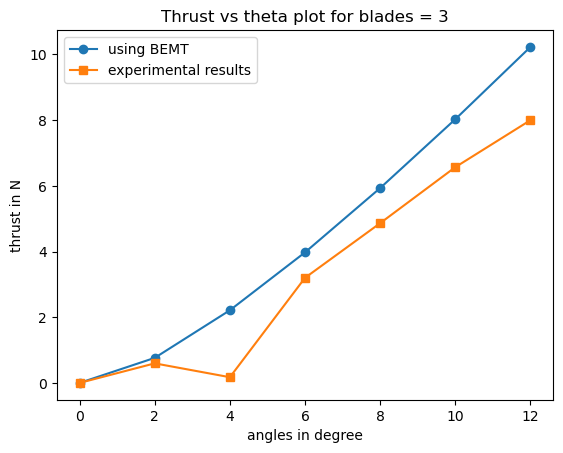

In [5]:
plt.plot(angles, thrusts, linestyle='-', marker='o', label="using BEMT")
plt.plot(angles, paper_thrust, linestyle='-', marker='s', label="experimental results")
plt.legend()
plt.title("Thrust vs theta plot for blades = 3")
plt.xlabel("angles in degree")
plt.ylabel("thrust in N")
plt.show()


In [6]:
paper_torques = np.array([0.000185,0.000206,0.000300,0.000474,0.000735,0.001048,0.001357])*x.rho*np.pi*x.r**3*(x.omega*x.r)**2

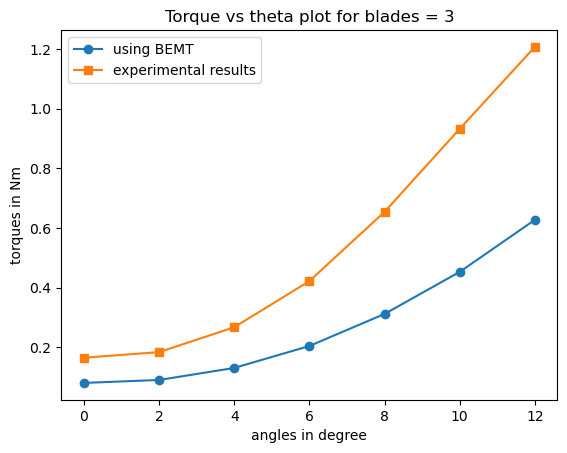

In [7]:
plt.plot(angles, torques, linestyle='-', marker='o', label="using BEMT")
plt.plot(angles, paper_torques, linestyle='-', marker='s', label="experimental results")
plt.legend()
plt.title("Torque vs theta plot for blades = 3")
plt.xlabel("angles in degree")
plt.ylabel("torques in Nm")
plt.show()


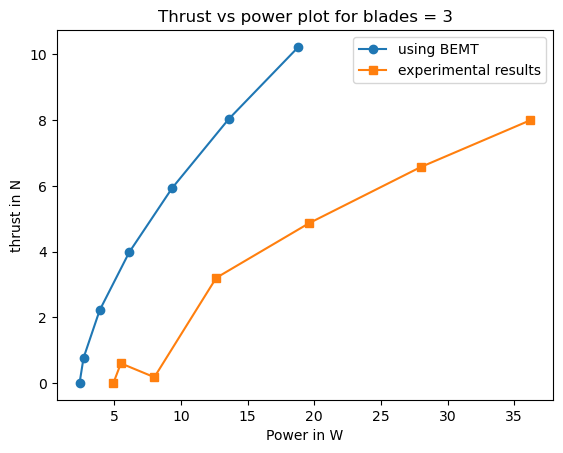

In [8]:
plt.plot(np.array(torques)*x.omega,thrusts, linestyle='-', marker='o', label="using BEMT")
plt.plot(paper_torques*x.omega,paper_thrust, linestyle='-', marker='s', label="experimental results")
plt.legend()
plt.title("Thrust vs power plot for blades = 3")
plt.ylabel("thrust in N")
plt.xlabel("Power in W")
plt.show()


## Design Variable Variations

### Plotting thrust and power vs the number of blades 

In [7]:
y_thrust =[]
y_power  =[]
x =[1,2,3,4,5,6]
for i in x :
    temp = rotor()
    temp.set_rotor(radius=0.762, root_cut_out=0.125, blades=i, chord0=0.0508, chord_slope=0,twist0 = np.deg2rad(6), twist_slope=0, omega=30)
    lambdas,v,sigma,twist, thrust ,dT,Fs,d_torque, torque = temp.bemt(V=0)
    y_thrust.append(thrust)
    y_power.append(torque*temp.omega)

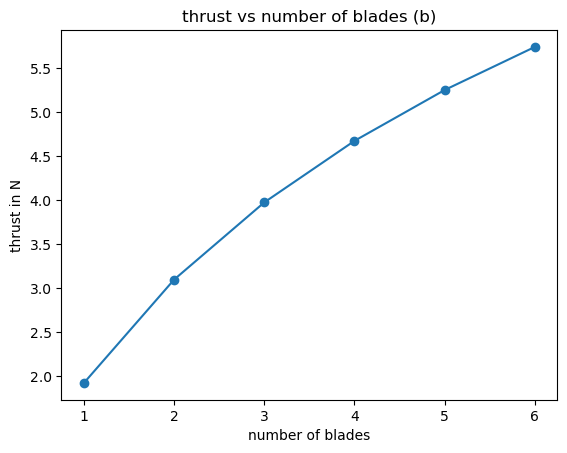

In [8]:
plt.plot(x,y_thrust,marker='o')
plt.title("thrust vs number of blades (b)")
plt.xlabel("number of blades")
plt.ylabel("thrust in N")
plt.show()

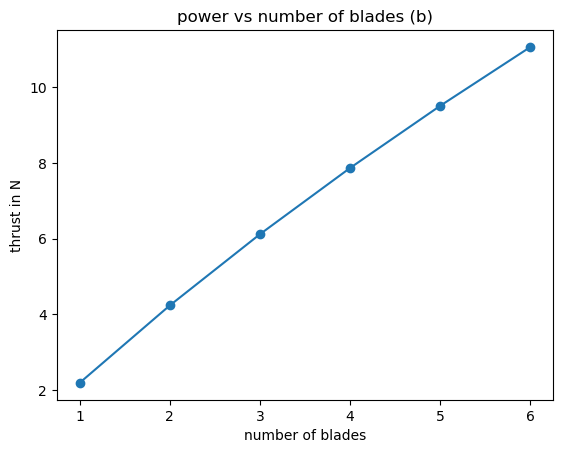

In [9]:
plt.plot(x,y_power,marker='o')
plt.title("power vs number of blades (b)")
plt.xlabel("number of blades")
plt.ylabel("thrust in N")
plt.show()

### plotting thrust and power vs taper ratio

In [10]:
y_thrust =[]
y_power  =[]
x = np.arange(0.1,1.1,0.1)
for i in x :
    temp = rotor()
    temp.set_rotor(radius=0.762, root_cut_out=0.125, blades=i, chord0=0.0508, chord_slope=((temp.chord * i - temp.chord)/(temp.r-temp.rc)),twist0 = np.deg2rad(6), twist_slope=0, omega=30)
    lambdas,v,sigma,twist, thrust ,dT,Fs,d_torque, torque = temp.bemt(V=0)
    y_thrust.append(thrust)
    y_power.append(torque*temp.omega)

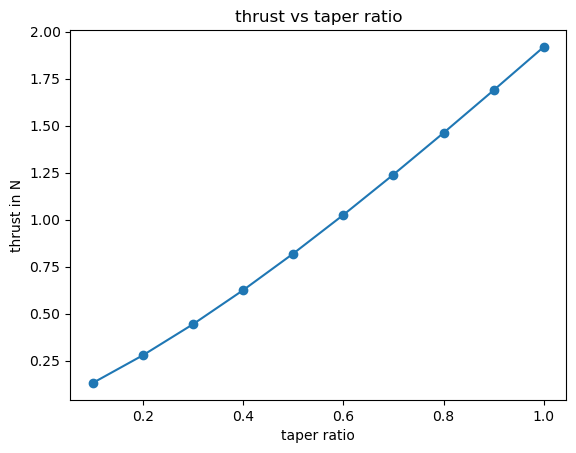

In [11]:
plt.plot(x,y_thrust,marker='o')
plt.title("thrust vs taper ratio")
plt.xlabel("taper ratio")
plt.ylabel("thrust in N")
plt.show()

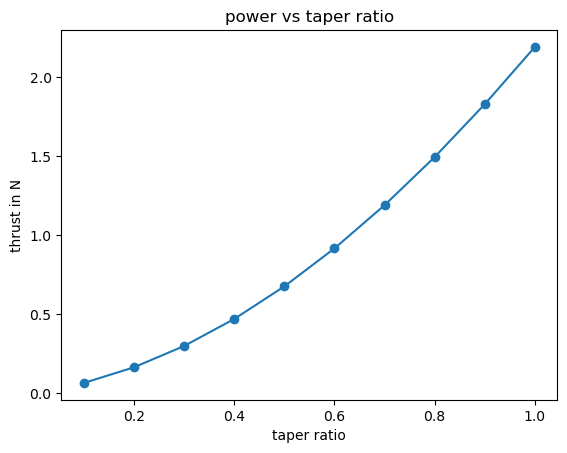

In [12]:
plt.plot(x,y_power,marker='o')
plt.title("power vs taper ratio")
plt.xlabel("taper ratio")
plt.ylabel("thrust in N")
plt.show()

### plotting thrust and power vs twist 

In [13]:
y_thrust =[]
y_power  =[]
start = np.deg2rad(8)    ### start at 8
copy = np.arange(0,9,1)
x = np.array(copy)

x = start - np.deg2rad(x)
for i in x :
    temp = rotor()
    temp.set_rotor(radius=0.762, root_cut_out=0.125, blades=i, chord0=0.0508, chord_slope=0,twist0 = start, twist_slope=-i, omega=30)
    lambdas,v,sigma,twist, thrust ,dT,Fs,d_torque, torque = temp.bemt(V=0)
    y_thrust.append(thrust)
    y_power.append(torque*temp.omega)

C:\Users\Admin\AppData\Local\Temp\ipykernel_5900\2015916412.py:104: RuntimeWarning: invalid value encountered in scalar divide
  nxt = np.sqrt((sigma*self.cl/(16*F) - self.lambda_c/2)**2  +  (sigma*self.cl/(8*F))*theta*(r/self.r)) + self.lambda_c/2 - sigma*self.cl/(16*F)


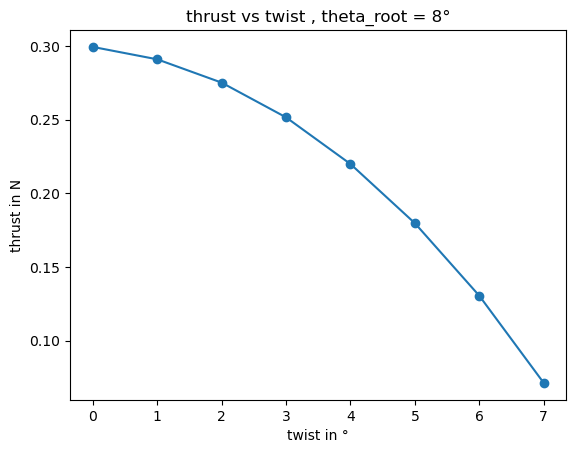

In [14]:
plt.plot(copy,y_thrust,marker='o')
plt.title("thrust vs twist , theta_root = 8°")
plt.xlabel("twist in °")
plt.ylabel("thrust in N")
plt.show()

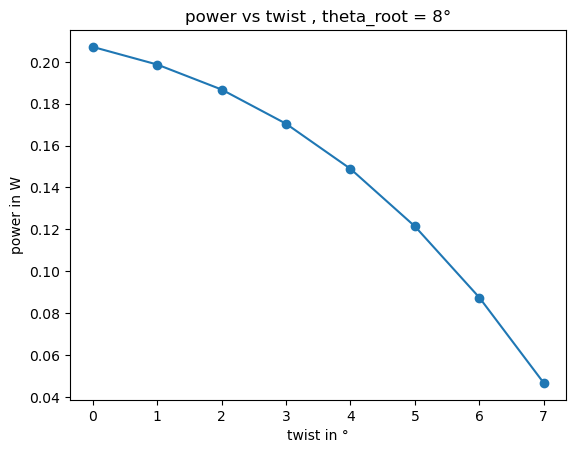

In [15]:
plt.plot(copy,y_power,marker='o')
plt.title("power vs twist , theta_root = 8°")
plt.xlabel("twist in °")
plt.ylabel("power in W")
plt.show()

## Mission Planner GROUP


In [84]:
import numpy as np

class MissionPlanner:
    def __init__(self, rotor, engine_power_kw=1000, sfc=1.389e-4):
        """
        @param rotor: rotor object (defined by user)
        @param engine_power_kw: Maximum engine shaft power available [kW]
        @param sfc: Specific fuel consumption [kg/kW-s]
        """
        self.rotor = rotor
        self.engine_power_kw = engine_power_kw
        self.sfc = sfc
        self.mission_log = []
        
        # Mission state
        self.takeoff_weight = None
        self.fuel_weight = None
        self.altitude = None
        self.gross_weight = None

    def mission_inputs(self, takeoff_weight, fuel_weight, altitude):
        """
        Set initial mission conditions.
        """
        self.takeoff_weight = takeoff_weight
        self.fuel_weight = fuel_weight
        self.gross_weight = takeoff_weight
        self.altitude = altitude
        self.rotor.atmosphere(altitude)
        self.log_event(f"Mission initialized at {altitude} m with weight {takeoff_weight} kg")

    def log_event(self, message):
        self.mission_log.append(message)
        print(message)

    def power_required_hover(self, climb_rate=0.0):
        """
        Estimate hover/vertical climb power required using BEMT.
        """
        _, _, _, _, thrust, _, _, _, torque = self.rotor.bemt(climb_rate)
        weight_N = self.gross_weight * 9.81
        if thrust < weight_N:
            self.log_event("WARNING: Rotor thrust insufficient for hover at this weight!")
        power_req = torque * self.rotor.omega/1000
        return power_req

    def fuel_burn(self, power_kw, duration_s, eff=0.9):
        """
        Compute fuel burned using SFC in kg/kW-s.
        Accounts for mechanical/transmission efficiency.
        
        @param power_kw: shaft power required [kW]
        @param duration_s: segment duration [s]
        @param eff: efficiency (fraction of fuel power that reaches rotor), default = 0.9
        """
        # Effective fuel power must be higher due to losses
        fuel_used = (power_kw / eff) * self.sfc * duration_s
        self.fuel_weight -= fuel_used
        self.gross_weight -= fuel_used
        if self.fuel_weight < 0:
            self.log_event("WARNING: Fuel exhausted!")
        return fuel_used


    def segment_hover(self, duration_s=300, climb_rate=0.0):
        """
        Hover or vertical climb segment.
        @param duration_s: duration in seconds
        """
        P_req = self.power_required_hover(climb_rate)
        P_avail = self.engine_power_kw
        if P_req > P_avail:
            self.log_event("WARNING: Engine power insufficient for hover!")
        fuel_used = self.fuel_burn(P_req, duration_s)
        self.log_event(f"Hover/Climb {duration_s:.0f} s @ {climb_rate:.1f} m/s | "
                       f"Power req = {P_req:.1f} kW | Fuel used = {fuel_used:.4f} kg")

    def segment_payload(self, payload_change):
        """
        Pickup (+) or drop (-) payload.
        """
        self.gross_weight += payload_change
        self.log_event(f"Payload change: {payload_change:+.1f} kg | New gross weight = {self.gross_weight:.1f} kg")

    def report(self):
        """
        Print mission summary.
        """
        print("\n--- Mission Summary ---")
        for log in self.mission_log:
            print(log)


In [99]:
omegas = np.arange(40,50,1)
fuel_burn_rates = []
gross_weights = []
sfc = 1.389 * (10**-7)  # kg / (Ws)
for i in omegas :
    temp = rotor()
    temp.atmosphere(h=2000)
    temp.set_rotor(omega = i,twist0=np.deg2rad(8),radius= 5.5,root_cut_out=0.8,chord0=0.4, blades=3)
    lambdas,v,sigma,twist, thrust ,dT,Fs,d_torque, torque = temp.bemt(V=0)
    power = torque*temp.omega*100/90   ### power loss of 90%, 90%x = torque*omega 
    print(thrust,power)
    gross_weights.append(thrust/9.81)
    fuel_burn_rates.append(power*sfc)
fuel_burn_rates = np.array(fuel_burn_rates) * 3600


28432.20238526068 490603.68510488974
29871.582631014506 528326.5090799079
31346.5031297499 567935.0909695481
32856.96388146687 609475.4248692887
34402.96488616543 652993.5048746084
35984.50614384555 698535.3250809858
37601.58765450725 746146.8795838994
39254.20941815053 795874.1624788278
40942.37143477538 847763.1678612495
42666.0737043818 901859.8898266435


Text(0, 0.5, 'fuel burn rate in kg/hr')

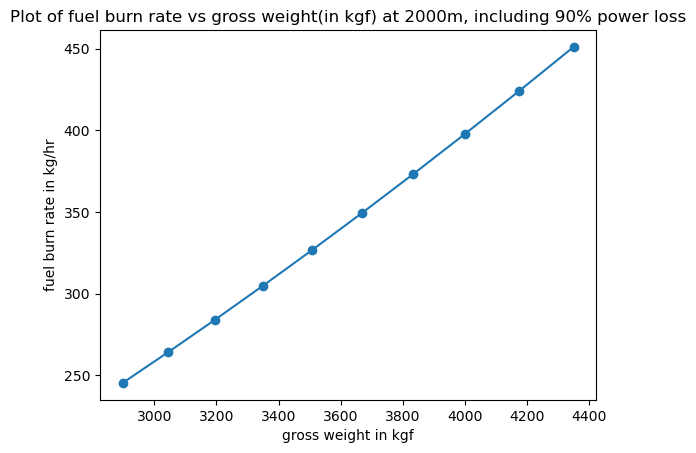

In [37]:
plt.plot(gross_weights,fuel_burn_rates,marker = 'o')
plt.title("Plot of fuel burn rate vs gross weight(in kgf) at 2000m, including 90% power loss")
plt.xlabel("gross weight in kgf")
plt.ylabel("fuel burn rate in kg/hr")

Text(0, 0.5, 'time in minutes')

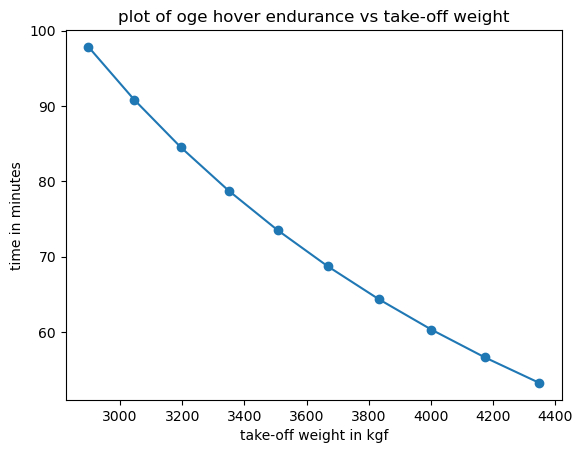

In [40]:
### assuming 400 kg fuel 
time = 400*60/(np.array(fuel_burn_rates))          ### fuel burn rates in kg/hr
plt.plot(gross_weights,time,marker='o')
plt.title("plot of oge hover endurance vs take-off weight")
plt.xlabel("take-off weight in kgf")
plt.ylabel("time in minutes")

In [51]:
temp = rotor()
temp.atmosphere(h=2000)
temp.set_rotor(omega = 45,twist0=np.deg2rad(8),radius= 5.5,root_cut_out=0.8,chord0=0.4, blades=3)  ### constant pitch for the rotor = 8º
mission = MissionPlanner(temp)
mission.mission_inputs(takeoff_weight=2500,fuel_weight=300,altitude= 2000)

mission.segment_hover(300,0)
mission.segment_hover(600,5)
mission.segment_hover(6000, 0)
mission.report()


Mission initialized at 2000 m with weight 2500 kg
Hover/Climb 300 s @ 0.0 m/s | Power req = 628.7 kW | Fuel used = 29.1080 kg
Hover/Climb 600 s @ 5.0 m/s | Power req = 593.2 kW | Fuel used = 54.9349 kg
Hover/Climb 6000 s @ 0.0 m/s | Power req = 628.7 kW | Fuel used = 582.1593 kg

--- Mission Summary ---
Mission initialized at 2000 m with weight 2500 kg
Hover/Climb 300 s @ 0.0 m/s | Power req = 628.7 kW | Fuel used = 29.1080 kg
Hover/Climb 600 s @ 5.0 m/s | Power req = 593.2 kW | Fuel used = 54.9349 kg
Hover/Climb 6000 s @ 0.0 m/s | Power req = 628.7 kW | Fuel used = 582.1593 kg


# Indivisual Helicopter 

| Parameter                        | Rotor 1 (Main Rotor)             | Rotor 2 (Tail Rotor)           |
|----------------------------------|----------------------------------|--------------------------------|
| **Rotor Description (role)**     | Main Rotor                       | Tail Rotor                     |
| **Airfoil**                      | NACA 0012                        | NACA 0010                      |
| **Rotor Radius (m)**             | 5.5 m                            | 1 m                            |
| **Rotor Speed (rad/s)**          | 40 rad/s                         | 150 rad/s                      |
| **Number of Blades**             | 3                                | 2                              |
| **Chord Length Variation**       | 0.45 − 0.05 (r − 0.8)            | 0.18 − 0.09 (r − 0.2)          |
| **Twist Variation**              | 12 − 1.6 (r − 0.8)               | 10 − 6.4 (r − 0.2)             |
| **Root Cutout**                  | 0.8 m                            | 0.2 m                          

C:\Users\Admin\AppData\Local\Temp\ipykernel_5900\2015916412.py:104: RuntimeWarning: invalid value encountered in sqrt
  nxt = np.sqrt((sigma*self.cl/(16*F) - self.lambda_c/2)**2  +  (sigma*self.cl/(8*F))*theta*(r/self.r)) + self.lambda_c/2 - sigma*self.cl/(16*F)


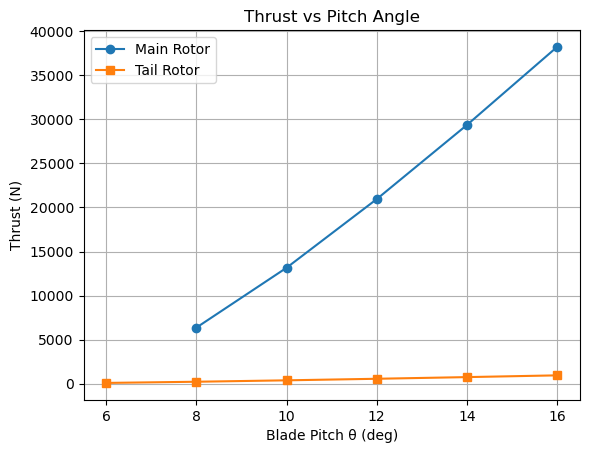

In [72]:
import numpy as np
import matplotlib.pyplot as plt

angles = [4,6,8,10,12,14,16]

# --- Main Rotor ---
main = rotor(); main.atmosphere(h=0)
main.set_airfoil(cl=5.75, cdo=0.0113, cd=1.25)
main_thrusts, main_torques = [], []
for pitch in angles:
    main.set_rotor(radius=5.5, root_cut_out=0.8, blades=3,
                   chord0=0.45, chord_slope=-0.05,
                   twist0=np.deg2rad(pitch), twist_slope=-np.deg2rad(1.6), omega=40)
    _,_,_,_, main_thrust,_,_,_, main_torque = main.bemt(V=0)
    main_thrusts.append(main_thrust)
    main_torques.append(main_torque)

# --- Tail Rotor ---
tail = rotor(); tail.atmosphere(h=0)
tail.set_airfoil(cl=5.75, cdo=0.0113, cd=1.25)
tail_thrusts, tail_torques = [], []
for pitch in angles:
    tail.set_rotor(radius=1, root_cut_out=0.2, blades=2,
                   chord0=0.18, chord_slope=-0.09,
                   twist0=np.deg2rad(pitch), twist_slope=-np.deg2rad(6.4), omega=150)
    _,_,_,_, tail_thrust,_,_,_, tail_torque = tail.bemt(V=0)
    tail_thrusts.append(tail_thrust)
    tail_torques.append(tail_torque)

# --- Plot ---
plt.plot(angles, main_thrusts, 'o-', label="Main Rotor")
plt.plot(angles, tail_thrusts, 's-', label="Tail Rotor")
plt.xlabel("Blade Pitch θ (deg)")
plt.ylabel("Thrust (N)")
plt.title("Thrust vs Pitch Angle")
plt.legend()
plt.grid(True)
plt.show()


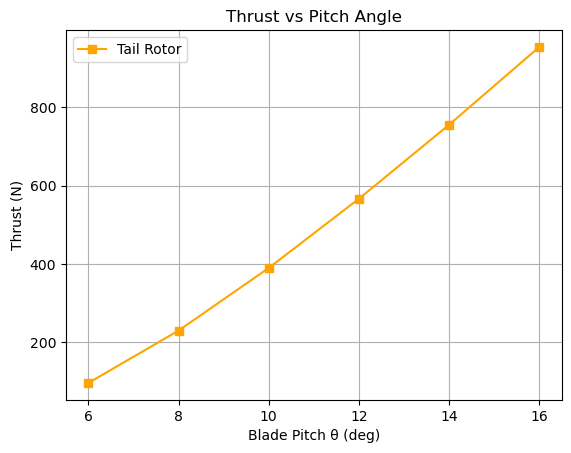

In [73]:
plt.plot(angles, tail_thrusts, 's-', label="Tail Rotor", color="orange")
plt.xlabel("Blade Pitch θ (deg)")
plt.ylabel("Thrust (N)")
plt.title("Thrust vs Pitch Angle")
plt.legend()
plt.grid(True)
plt.show()


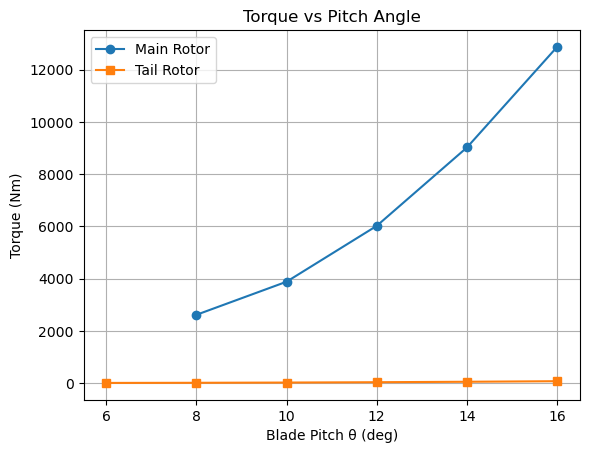

In [78]:
# --- Plot ---
plt.plot(angles, main_torques, 'o-', label="Main Rotor")
plt.plot(angles, tail_torques, 's-', label="Tail Rotor")
plt.xlabel("Blade Pitch θ (deg)")
plt.ylabel("Torque (Nm)")
plt.title("Torque vs Pitch Angle")
plt.legend()
plt.grid(True)
plt.show()

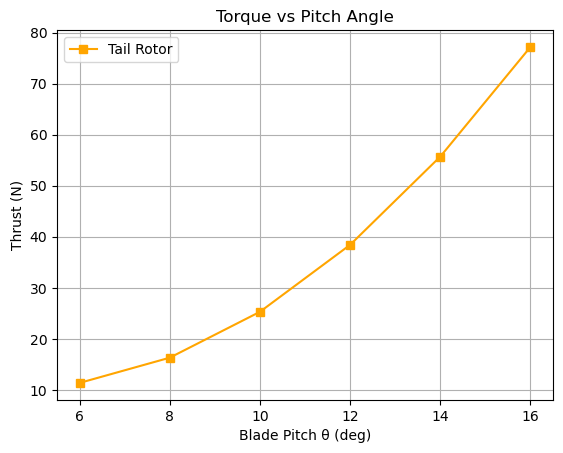

In [77]:
plt.plot(angles, tail_torques, 's-', label="Tail Rotor", color="orange")
plt.xlabel("Blade Pitch θ (deg)")
plt.ylabel("Thrust (N)")
plt.title("Torque vs Pitch Angle")
plt.legend()
plt.grid(True)
plt.show()

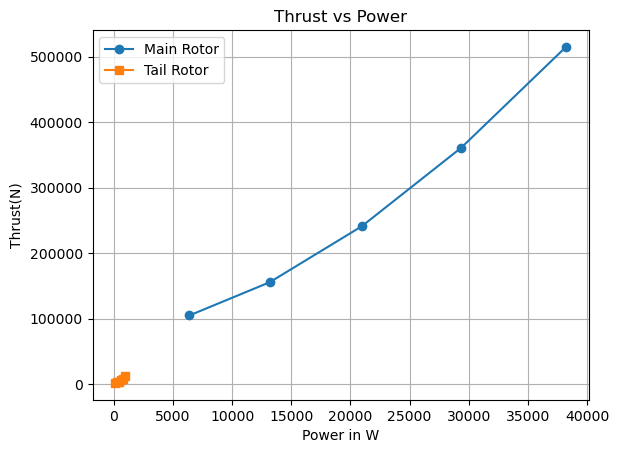

In [80]:
# --- Plot ---
plt.plot(main_thrusts, np.array(main_torques)*main.omega, 'o-', label="Main Rotor")
plt.plot(tail_thrusts, tail.omega * np.array(tail_torques), 's-', label="Tail Rotor")
plt.xlabel("Power in W")
plt.ylabel("Thrust(N)")
plt.title("Thrust vs Power")
plt.legend()
plt.grid(True)
plt.show()

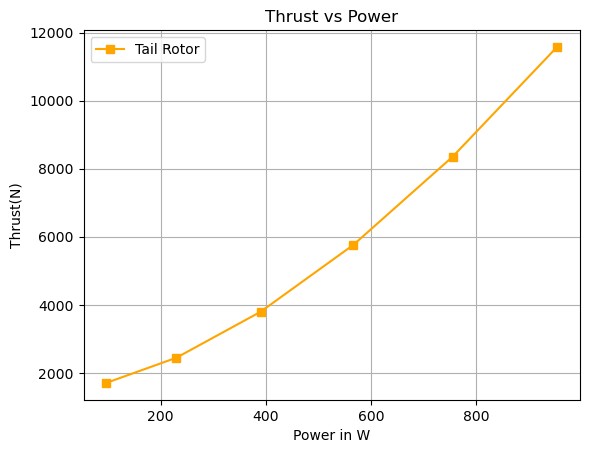

In [82]:
plt.plot(tail_thrusts, tail.omega * np.array(tail_torques), 's-', label="Tail Rotor",color= 'orange')
plt.xlabel("Power in W")
plt.ylabel("Thrust(N)")
plt.title("Thrust vs Power")
plt.legend()
plt.grid(True)
plt.show()

# Hover mission test 

In [92]:
main = rotor()
main.atmosphere(h=2000)
main.set_rotor(radius=5.5, root_cut_out=0.8, blades=3,
                   chord0=0.45, chord_slope=-0.05,
                   twist0=np.deg2rad(pitch), twist_slope=-np.deg2rad(1.6), omega=45)
_,_,_,_, main_thrust,_,_,_, main_torque = main.bemt(V=0)
mission = MissionPlanner(main)
mission.mission_inputs(takeoff_weight=3000,fuel_weight=400,altitude= 2000)

mission.segment_hover(300,0)
mission.segment_hover(600,5)
mission.segment_hover(600, 0)
mission.report()


Mission initialized at 2000 m with weight 3000 kg
Hover/Climb 300 s @ 0.0 m/s | Power req = 691.0 kW | Fuel used = 31.9938 kg
Hover/Climb 600 s @ 5.0 m/s | Power req = 667.9 kW | Fuel used = 61.8442 kg
Hover/Climb 600 s @ 0.0 m/s | Power req = 691.0 kW | Fuel used = 63.9877 kg

--- Mission Summary ---
Mission initialized at 2000 m with weight 3000 kg
Hover/Climb 300 s @ 0.0 m/s | Power req = 691.0 kW | Fuel used = 31.9938 kg
Hover/Climb 600 s @ 5.0 m/s | Power req = 667.9 kW | Fuel used = 61.8442 kg
Hover/Climb 600 s @ 0.0 m/s | Power req = 691.0 kW | Fuel used = 63.9877 kg


31811.394016615395 454184.69243546366
33421.84583870655 489107.23730225925
35072.06190331848 525775.5545806037
36762.04221045117 564232.2240854127
38491.78676010463 604519.825631602
40261.29555227887 646680.9390340878
42070.56858697386 690758.1441077858
43919.60586418963 736794.0206676116
45808.40738392617 784831.1485284811
47736.973146183474 834912.1075053102


Text(0, 0.5, 'fuel burn rate in kg/hr')

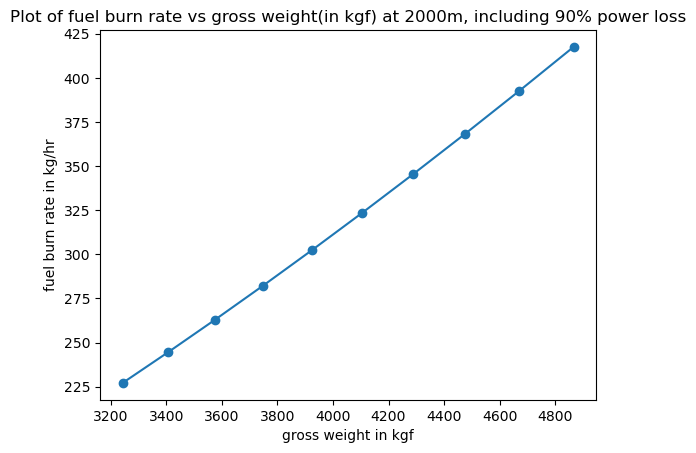

In [100]:
omegas = np.arange(40,50,1)
fuel_burn_rates = []
gross_weights = []
sfc = 1.389 * (10**-7)  # kg / (Ws)
for i in omegas :
    temp = rotor()
    temp.atmosphere(h=2000)
    temp.set_rotor(radius=5.5, root_cut_out=0.8, blades=3,
                   chord0=0.45, chord_slope=-0.05,
                   twist0=np.deg2rad(15), twist_slope=-np.deg2rad(1.6), omega=i)

    lambdas,v,sigma,twist, thrust ,dT,Fs,d_torque, torque = temp.bemt(V=0)
    power = torque*temp.omega*100/90   ### power loss of 90%, 90%x = torque*omega 
    print(thrust,power)
    gross_weights.append(thrust/9.81)
    fuel_burn_rates.append(power*sfc)
fuel_burn_rates = np.array(fuel_burn_rates) * 3600

plt.plot(gross_weights,fuel_burn_rates,marker = 'o')
plt.title("Plot of fuel burn rate vs gross weight(in kgf) at 2000m, including 90% power loss")
plt.xlabel("gross weight in kgf")
plt.ylabel("fuel burn rate in kg/hr")

Text(0, 0.5, 'time in minutes')

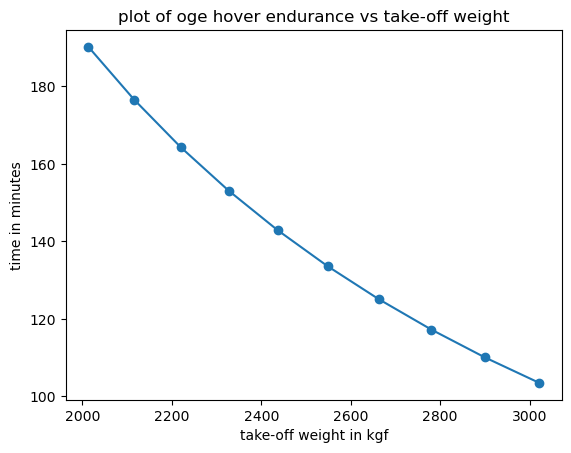

In [86]:
### assuming 400 kg fuel 
time = 400*60/(np.array(fuel_burn_rates))          ### fuel burn rates in kg/hr
plt.plot(gross_weights,time,marker='o')
plt.title("plot of oge hover endurance vs take-off weight")
plt.xlabel("take-off weight in kgf")
plt.ylabel("time in minutes")

## maximum thrust for main and tail rotors, based on the stall at 15°

916.1830840047007 12572.121325794395
939.2308147116942 13049.493612307615
962.5648526324388 13538.799592110556
986.185197766935 14040.186594750001
1010.0918501151828 14553.80194977274
1034.2848096771818 15079.792986725553
1058.7640764529324 15618.307035155232
1083.5296504424346 16169.491424608566
1108.581531645688 16733.49348463234
1133.9197200626932 17310.460544773337


Text(0, 0.5, 'fuel burn rate in kg/hr')

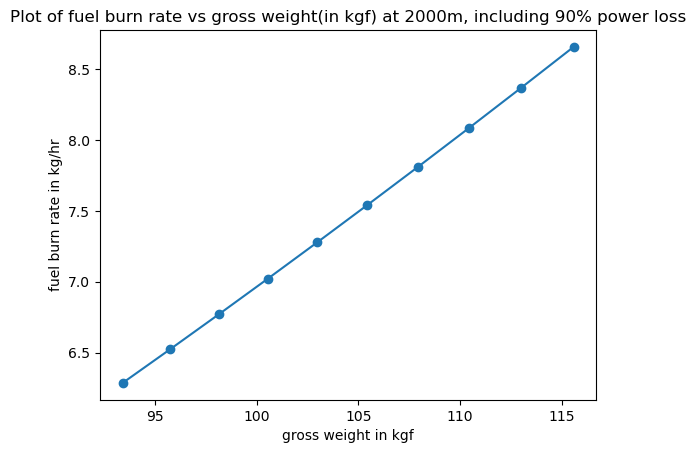

In [106]:
omegas = np.arange(160,180,2)
fuel_burn_rates = []
gross_weights = []
sfc = 1.389 * (10**-7)  # kg / (Ws)
for i in omegas :
    temp = rotor()
    temp.atmosphere(h=2000)
    temp.set_airfoil(cl=5.75, cdo=0.0113, cd=1.25)
    temp.set_rotor(radius=1, root_cut_out=0.2, blades=2,
                   chord0=0.18, chord_slope=-0.09,
                   twist0=np.deg2rad(15), twist_slope=-np.deg2rad(6.4), omega=i)
    _,_,_,_, tail_thrust,_,_,_, tail_torque = temp.bemt(V=0)

    lambdas,v,sigma,twist, thrust ,dT,Fs,d_torque, torque = temp.bemt(V=0)
    power = torque*temp.omega*100/90   ### power loss of 90%, 90%x = torque*omega 
    print(thrust,power)
    gross_weights.append(thrust/9.81)
    fuel_burn_rates.append(power*sfc)
fuel_burn_rates = np.array(fuel_burn_rates) * 3600

plt.plot(gross_weights,fuel_burn_rates,marker = 'o')
plt.title("Plot of fuel burn rate vs gross weight(in kgf) at 2000m, including 90% power loss")
plt.xlabel("gross weight in kgf")
plt.ylabel("fuel burn rate in kg/hr")